In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px

In [2]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cluster import KMeans 
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [3]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-4-heart.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

In [5]:
# mean_imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

# data[['ALP','CHOL','ALB','ALT','PROT']] = mean_imp.fit_transform(data[['ALP','CHOL','ALB','ALT','PROT']])

In [6]:
mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

In [7]:
data.duplicated().sum()

data.drop_duplicates(inplace=True, ignore_index=False, subset=None, keep='first')

data.duplicated().sum()

0

<AxesSubplot:title={'center':'Correlation Matrix'}>

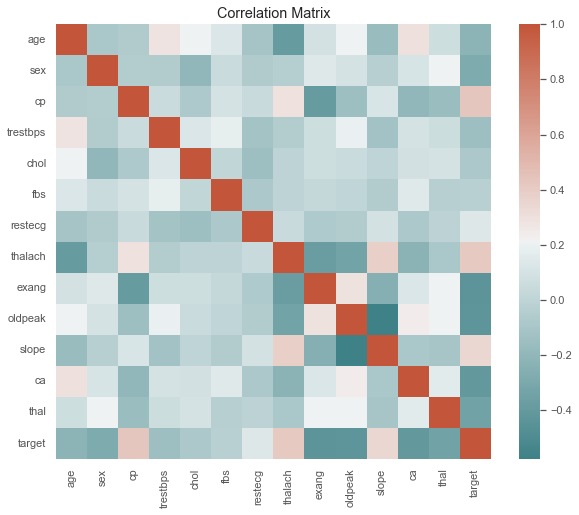

In [8]:
f,ax = plt.subplots(figsize=(10,8))

data_corr = data.corr()

ax.set_title('Correlation Matrix')
sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_),cmap=sns.diverging_palette(200,20, as_cmap=True), ax=ax, square=True)

In [ ]:
y = data.target 
x = data.drop(columns=['target'])